In [1]:
!pip install pandas
!pip install scikit-learn
!pip install lingam
!pip install fsspec
!pip install s3fs
!pip install pyarrow

!pip install ydata-profiling
!pip install --upgrade --force-reinstall setuptools




[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.5.1 which is incompatible.
pandas-profiling 3.2.0 requires visions[type_image_path]==0.7.4, but you have visions 0.8.1 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 80.8.0
    Uninstalling setuptools-80.8.0:
      Successfully uninstalled setuptools-80.8.0



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
# os.system("pip install lingam")
# os.system("pip install fsspec")
# os.system("pip install s3fs")
# os.system("pip install pyarrow")

import random as rnd
from scipy.spatial import distance
import pandas as pd
from sklearn import preprocessing
import warnings
import sys
import argparse
import ast
import time
import json

#German
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split

from ydata_profiling import ProfileReport
from scipy.stats import normaltest
import statsmodels.api as sm


import pickle

import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

import random as rnd

# from IPython.display import display

import warnings

warnings.filterwarnings('ignore')

c:\Users\OmarKrauss\Desktop\pessoal\tcc\tcc\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import os
# os.system("pip install lingam")
# os.system("pip install fsspec")
# os.system("pip install s3fs")
# os.system("pip install pyarrow")

import random as rnd
from scipy.spatial import distance
import pandas as pd
from sklearn import preprocessing
import warnings
import sys
import argparse
import ast
import time
import json

#German
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split

from ydata_profiling import ProfileReport
from scipy.stats import normaltest
import statsmodels.api as sm


import pickle

import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

import random as rnd

# from IPython.display import display

import warnings

warnings.filterwarnings('ignore')

# s3 = boto3.client('s3')

#Used for ordering evaluations
class individual:
    def __init__(self, index, score, distance, num_changes, aval_norm, dist_norm, predict_proba):
        self.index = index #Indicates the instance's position in the dataframe
        self.score = score #Indicates the score in relation to the proximity of the class boundary
        self.distance = distance #Indicates the distance from the original instance
        self.num_changes = num_changes #Indicates the number of changes for class change
        self.aval_norm = aval_norm #Indicates the final fitness with standardized metrics
        self.dist_norm = dist_norm #Indicates the normalized distance (distance and number of changes)
        self.predict_proba = predict_proba #Indicates de individual's class
    def __repr__(self):
        return repr((self.index, self.score, self.distance, self.num_changes, self.aval_norm, self.dist_norm, self.predict_proba))

class counter_change:
    def __init__(self, column, value):
        self.column = column 
        self.value = value
    def __eq__(self, other):
        if self.column == other.column and self.value == other.value:
            return True
        else:
            return False
    def __repr__(self):
        return repr((self.column, self.value))    

#Used to generate a random value in the mutation operation
class feature_range:
    def __init__(self, column, col_type, min_value, max_value):
        self.column = column 
        self.col_type = col_type
        self.min_value = min_value
        self.max_value = max_value

    #Returns a random value to perform mutation operation
    def get_random_value(self):
        if self.col_type == 'int64' or self.col_type == 'int' or self.col_type == 'int16' or self.col_type == 'int8' or (self.col_type == 'uint8'):
            value = rnd.randint(self.min_value, self.max_value)
        else:  
            value = round(rnd.uniform(self.min_value, self.max_value), 2)
        return value
    
    #Checks if the attribute has only one value.
    def unique_value(self):
        if self.min_value != self.max_value:
            return False
        else:  
            return True    

    def __repr__(self):
        return repr((self.column, self.col_type, self.min_value, self.max_value)) 
        
class CSSE(object):
    
    def __init__(self, input_dataset, model, static_list = [], K = 3, num_gen = 30, pop_size = 100, per_elit = 0.1, cros_proba = 0.8, mutation_proba = 0.1, L1 = 1, L2 = 1):
        #User Options
        self.static_list = static_list #List of static features
        self.K = K #Number of counterfactuals desired
        #Model
        self.input_dataset = input_dataset
        self.model = model
        #GA Parameters
        self.num_gen = num_gen
        self.pop_size = pop_size
        self.per_elit = per_elit
        self.cros_proba = cros_proba
        self.mutation_proba = mutation_proba
        #Objective function parameters
        self.L1 = L1 #weight assigned the distance to the original instance
        self.L2 = L2 #weight assigned the number of changes needed in the original instance   
    
    #Get which index in the SHAP corresponding to the current class
    def getBadClass(self):   
        if self.current_class == self.model.classes_[0]:
            ind_cur_class = 0
        else:
            ind_cur_class = 1
        
        return ind_cur_class
    
    #Gets the valid values range for each feature
    def getFeaturesRange(self):
        features_range = []
       
        for i in range (0, self.input_dataset.columns.size):
            col_name = self.input_dataset.columns[i]
            col_type = self.input_dataset[col_name].dtype
            min_value = min(self.input_dataset[col_name])
            max_value = max(self.input_dataset[col_name])
            
            feature_range_ind = feature_range(col_name, col_type, min_value, max_value)
            features_range.append(feature_range_ind)
        
        return features_range
       
    def getMutationValue(self, currentValue, index, ind_feature_range):
        new_value = ind_feature_range.get_random_value()
        
        while currentValue == new_value:
            new_value = ind_feature_range.get_random_value()
        
        return new_value
    
    def equal(self, individual, population):
        aux = 0
        for i in range ( 1, len(population)):
            c = population.loc[i].copy()
            dst = distance.euclidean(individual, c)
            if dst == 0:
                aux = 1
        
        return aux

    def getPopInicial (self, df, features_range): 
        #The reference individual will always be in the 0 position of the df - so that it is normalized as well (it will be used later in the distance function)
        df.loc[0] = self.original_ind.copy()
        
        #Counting numbers of repeated individuals
        number_repetitions = 0
        
        #One more position is used because the zero position was reserved for the reference individual
        while len(df) < self.pop_size + 1:
            #Draw a feature to change
            index_a = rnd.randint( 0, self.input_dataset.columns.size - 1 )
            while df.columns[index_a] in self.static_list:
                index_a = rnd.randint( 0, self.input_dataset.columns.size - 1 )
                
            if not features_range[index_a].unique_value():
                #Mutation
                mutant = self.original_ind.copy()

                new_value =  self.getMutationValue(mutant.iloc[index_a], index_a, features_range[index_a])
                mutant.iloc[index_a] = new_value

                ni = self.equal(mutant, df)
                if ni == 0:
                    df.loc[len(df)] = mutant.copy()
                else:
                    #Assesses whether the GA is producing too many repeated individuals.
                    number_repetitions = number_repetitions + 1
                    if number_repetitions == 2*self.pop_size:
                        self.pop_size = round(self.pop_size - self.pop_size*0.1)
                        self.mutation_proba = self.mutation_proba + 0.1
                        #print('Adjusting population size...', self.pop_size)
                        number_repetitions = 0
    
    #Complete the standardized proximity and similarity assessments for each individual
    def getNormalEvaluation(self, evaluation, aval_norma):
        scaler2 = preprocessing.MinMaxScaler()
        aval_norma2 = scaler2.fit_transform(aval_norma)
    
        i = 0
        while i < len(evaluation):
            evaluation[i].aval_norm = self.L1*aval_norma2[i,0] + self.L2*aval_norma2[i,1] + aval_norma2[i,2]
            evaluation[i].dist_norm = self.L1*aval_norma2[i,0] + self.L2*aval_norma2[i,1]
        
            i = i + 1
    
    def numChanges(self, ind_con):
        num = 0
        for i in range(len(self.original_ind)):
            if self.original_ind[i] != ind_con[i]:
                num = num + 1
        
        return num
        
    def fitness(self, population, evaluation, ind_cur_class):
        def getProximityEvaluation (proba):
            #Penalizes the individual who is in the negative class
            if proba < 0.5:
                predict_score = 0
            else:
                predict_score= proba
             
            return predict_score
               
        #Calculates similarity to the original instance
        def getEvaluationDist (ind, X_train_minmax):
            #Normalizes the data so that the different scales do not bias the distance
            a = X_train_minmax[0]
            b = X_train_minmax[ind]
            dst = distance.euclidean(a, b)
  
            return dst
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
        
            predict_proba = self.model.predict_proba(population)
                    
        #Calculating the distance between instances
        scaler = preprocessing.MinMaxScaler()
        X_train_minmax = scaler.fit_transform(population)
    
        i = 0
        aval_norma = [] 
        while i < len(population):
            proximityEvaluation = getProximityEvaluation(predict_proba[i, ind_cur_class])
            evaldist = getEvaluationDist(i, X_train_minmax)
            #The original individual is in the 1st position
            numChanges = self.numChanges(population.loc[i])
        
            ind = individual(i, proximityEvaluation, evaldist, numChanges, 0, 0, predict_proba[i, ind_cur_class])
            aval_norma.append([evaldist, numChanges, proximityEvaluation])
            evaluation.append(ind)
            i = i + 1

        self.getNormalEvaluation(evaluation, aval_norma)
       
    #Given a counterfactual solution returns the list of modified columns
    def getColumns(self, counter_solution):
        colums = []
        for j in range (0, len(counter_solution)):
            colums.append(counter_solution[j].column)
        
        return colums      
             
    #Checks if the new solution is contained in the solutions already found
    def contained_solution(self, original_instance, current_list, current_column_list, new_solution, new_column_solution):
        contained = False
        for i in range (0, len(current_list)):              
            if set(current_column_list[i]).issubset(new_column_solution):
                for j in range (0, len(current_list[i])):
                    pos = new_column_solution.index(current_list[i][j].column)
                    distancia_a = abs(original_instance[current_list[i][j].column] - current_list[i][j].value)
                    distancia_b = abs(original_instance[current_list[i][j].column] - new_solution[pos].value)
                    if distancia_b >= distancia_a:
                        contained = True

        return contained
      
    def elitism(self, evaluation, df, parents):
         
        num_elit = round(self.per_elit*self.pop_size)
        
        aval = []
        aval = evaluation.copy()
        aval.sort(key=lambda individual: individual.aval_norm)
        
        #contrafactual_ind = pd.DataFrame(columns=self.input_dataset.columns)
        solution_list = []
        solution_colums_list = []
        
        i = 0
        numContraf = 0
        while i < len(aval) and numContraf <= num_elit + 1:
            #Checks if the example belongs to the counterfactual class
            if aval[i].predict_proba < 0.5:
                ind_changes = []
                ind_colums_change = []
         
                #Gets counterfactual example change list
                ind_changes = self.getChanges(aval[i].index, parents)
                #Generates the list of columns modified in the counterfactual to check if there is already a solution with that set of columns
                ind_colums_change = self.getColumns(ind_changes)
                
                if ind_colums_change not in solution_colums_list:
                    #Check if one solution is a subset of the other
                    if not self.contained_solution(self.original_ind, solution_list, solution_colums_list, ind_changes, ind_colums_change):
                        #Include counterfactual in the list of examples of the final solution                    
                        df.loc[len(df)] = parents.iloc[aval[i].index].copy()                     
                                
                        #Add to the list of solutions (changes only)       
                        solution_list.append(ind_changes)
                        #Used to compare with the next counterfactuals (to ensure diversity)
                        solution_colums_list.append(ind_colums_change)
                                        
                        numContraf = numContraf + 1
                      
            i = i + 1
        return solution_list
    
    def roulette_wheel(self, evaluation):
        summation = 0
        #Performs roulette wheel to select parents who will undergo genetic operations
        for i in range (1, len(evaluation)): 
            summation = summation + 1/evaluation[i].aval_norm
    
        roulette = rnd.uniform( 0, summation )
    
        roulette_score = 1/evaluation[1].aval_norm
        i = 1
        while roulette_score < roulette:
            i += 1
            roulette_score += 1/evaluation[i].aval_norm
        
        return i
            
    def crossover (self, df, parents, evaluation, number_cross_repetitions):
        child = []
            
        corte = rnd.randint( 0, self.input_dataset.columns.size - 1 )
            
        index1 = self.roulette_wheel(evaluation)
        index2 = self.roulette_wheel(evaluation)
        
        ind_a = parents.iloc[index1].copy()
        ind_b = parents.iloc[index2].copy()
            
        crossover_op = rnd.random()
        if crossover_op <= self.cros_proba:
            child[ :corte ] = ind_a[ :corte ].copy()
            child[ corte: ] = ind_b[ corte: ].copy()
        else:
            child = ind_a.copy()
        
        ni = self.equal(child, df)
        if ni == 0:
            df.loc[len(df)] = child.copy()
        else:
            #Assesses whether the GA is producing too many repeated individuals.
            number_cross_repetitions = number_cross_repetitions + 1
            if number_cross_repetitions == self.pop_size:
                self.pop_size = round(self.pop_size - self.pop_size*0.1)
                self.mutation_proba = self.mutation_proba + 0.1
                #print('Adjusting population size...', self.pop_size)
                number_cross_repetitions = 0
        #    print('repeated')
        return number_cross_repetitions
                       
    def mutation (self, df, individual_pos, features_range):
        ni = 1
        #Does not allow repeated individual
        while ni == 1:
            #Draw a feature to change
            index_a = rnd.randint( 0, self.input_dataset.columns.size - 1 )
            while df.columns[index_a] in self.static_list:
                index_a = rnd.randint( 0, self.input_dataset.columns.size - 1 )
            
            if not features_range[index_a].unique_value():
                #Mutation
                mutant = df.iloc[individual_pos].copy()
            
                #Draw the value to be changed
                new_value =  self.getMutationValue(mutant.iloc[index_a], index_a, features_range[index_a])  
                mutant.iloc[index_a] = new_value

                ni = self.equal(mutant, df)
                if ni == 0:
                    df.loc[individual_pos] = mutant.copy()
                #else:
                #    print('repeated')
     
    def getChanges(self, ind, dfComp):
        changes = []
        
        for i in range (len(dfComp.iloc[ind])):
            if self.original_ind[i] != dfComp.loc[ind][i]:
                counter_change_ind = counter_change(dfComp.columns[i], dfComp.loc[ind][i])
                changes.append(counter_change_ind)

        return changes
    
    #Generates the solution from the final population
    def getContrafactual(self, df, aval):
        
        contrafactual_ind = pd.DataFrame(columns=self.input_dataset.columns)
        solution_list = []
        solution_colums_list = []
        
        i = 0
        numContraf = 0
        while i < len(aval) and numContraf < self.K:
            #Checks if the example belongs to the counterfactual class
            if aval[i].predict_proba < 0.5:
                ind_changes = []
                ind_colums_change = []
         
                #Gets counterfactual example change list
                ind_changes = self.getChanges(aval[i].index, df)
                #Generates the list of columns modified in the counterfactual to check if there is already a solution with that set of columns
                ind_colums_change = self.getColumns(ind_changes)
                
                if ind_colums_change not in solution_colums_list:
                    #Check if one solution is a subset of the other
                    if not self.contained_solution(self.original_ind, solution_list, solution_colums_list, ind_changes, ind_colums_change):
                        #Include counterfactual in the list of examples of the final solution
                        contrafactual_ind.loc[len(contrafactual_ind)] = df.iloc[aval[i].index].copy()
                                
                        #Add to the list of solutions (changes only)       
                        solution_list.append(ind_changes)
                        #Used to compare with the next counterfactuals (to ensure diversity)
                        solution_colums_list.append(ind_colums_change)
                                        
                        numContraf = numContraf + 1
                        #print('solution_list ', solution_list)
                    #else:
                        #print('is contained ', ind_changes)
                #else:
                    #print('repeated ', ind_changes)
                      
            i = i + 1

        return contrafactual_ind, solution_list   
    
    def printResults(self, solution):
        print("Result obtained")
        if len(solution) != 0:
            for i in range(0, len(solution)): 
                print("\n")
                print(f"{'Counterfactual ' + str(i + 1):^34}")
                for j in range(0, len(solution[i])): 
                    print(f"{str(solution[i][j].column):<29} {str(solution[i][j].value):>5}")
        else:
            print('Solution not found. It may be necessary to adjust the parameters for this instance.')
                                                 
    def explain(self, original_ind, current_class):
        self.original_ind = original_ind #Original instance
        #self.ind_cur_class = ind_cur_class #Index in the shap corresponds to the original instance class
        self.current_class = current_class #Original instance class
        
        ind_cur_class = self.getBadClass()
    
        #Gets the valid values range of each feature
        features_range = []
        features_range = self.getFeaturesRange()

        #The DataFrame df will have the current population
        df = pd.DataFrame(columns=self.input_dataset.columns)
        
        #Generates the initial population with popinitial mutants        
        self.getPopInicial(df, features_range)
        for g in range(self.num_gen):
            #To use on the parents of each generation
            parents = pd.DataFrame(columns=self.input_dataset.columns)
    
            #Copy parents to the next generation
            parents = df.copy()
            #df will contain the new population
            df = pd.DataFrame(columns=self.input_dataset.columns)
            
            evaluation = []                         
                   
            #Assessing generation counterfactuals
            self.fitness(parents, evaluation, ind_cur_class)
            #The original individual will always be in the 0 position of the df - So that it is normalized too (it will be used later in the distance function)
            df.loc[0] = self.original_ind.copy()
            
            #Copies to the next generation the per_elit best individuals
            self.elitism(evaluation, df, parents)
            number_cross_repetitions = 0
            while len(df) < self.pop_size + 1: #+1, as the 1st position is used to store the reference individual
                number_cross_repetitions = self.crossover(df, parents, evaluation, number_cross_repetitions)
                
                mutation_op = rnd.random()
                if mutation_op <= self.mutation_proba:
                    self.mutation(df, len(df) - 1, features_range)
            
            print()
                 
        evaluation = []
    
        #Evaluating the latest generation
        self.fitness(df, evaluation, ind_cur_class)
    
        #Order the last generation by distance to the original instance     
        evaluation.sort(key=lambda individual: individual.aval_norm)     
        
        #Getting the counterfactual set
        contrafactual_set = pd.DataFrame(columns=self.input_dataset.columns)
        contrafactual_set, solution_list = self.getContrafactual(df, evaluation)       
                 
        return contrafactual_set, solution_list
    
    
    




class CCSSE:
    def __init__(self, dataset, class_name,  bb_model, samples = None, K = 5, generation = 10, dataset_size = 'all'):
        self.df_main = dataset
        self.class_name = class_name
        self.samples = samples
        self.K = K
        self.generation = generation
        
#         self.x_train, self.x_test, self.y_train, self.y_test, self.dfx_full, self.dfy_full = self.get_datasets_train_test()
        # self.x_train, self.x_test, self.y_train, self.y_test, self.dfx_full, self.dfy_full = self.get_dataset()
        
        self.x_train, self.x_test, self.y_train, self.y_test, self.dfx_full, self.dfy_full = self.get_especific_dataset()
        print('completou get_especific_dataset')
        self.bb_model, self.p = self.get_bb_model(bb_model)
        print('completou get_bb_model')
        self.explainerCSSE = self.get_model_contrafactual()
        print('completou get_model_contrafactual')
        self.model_causal, self.df_causal_effects, self.df_error, self.causal_order = self.get_model_causality()
        print('completou get_model_causality')
        self.run_dict = {}
        self.run_non_causal_dict = {}
        
    def load_df_dataset(self):
        def convert_to_list(val):
            try:
                return ast.literal_eval(val) if isinstance(val, str) and val.startswith('[') and val.endswith(']') else val
            except (ValueError, SyntaxError):
                return val
            
        df = pd.read_parquet("dfm_use.parquet")
        df['path'] = df['path'].apply(convert_to_list)
        
        return df
    
    def _search_causal_order(self, matrix):
        """Obtain a causal order from the given matrix strictly.

        Parameters
        ----------
        matrix : array-like, shape (n_features, n_samples)
            Target matrix.

        Return
        ------
        causal_order : array, shape [n_features, ]
            A causal order of the given matrix on success, None otherwise.
        """
        
        causal_order = []

        row_num = matrix.shape[0]
        original_index = np.arange(row_num)

        while 0 < len(matrix):
            # find a row all of which elements are zero
            row_index_list = np.where(np.sum(np.abs(matrix), axis=1) == 0)[0]
            if len(row_index_list) == 0:
                break

            target_index = row_index_list[0]

            # append i to the end of the list
            causal_order.append(original_index[target_index])
            original_index = np.delete(original_index, target_index, axis=0)

            # remove the i-th row and the i-th column from matrix
            mask = np.delete(np.arange(len(matrix)), target_index, axis=0)
            matrix = matrix[mask][:, mask]

        if len(causal_order) != row_num:
            causal_order = None

        return causal_order
    
    def get_especific_dataset(self):
        columns = self.df_main.columns
        columns_tmp = list(columns)
        print(f"class_name = {self.class_name}")
        print(f"columns_tmp = {columns_tmp}")
        columns_tmp.remove(self.class_name)

        # Separa as amostras específicas
        df_samples = self.df_main.loc[self.samples]
        df_remaining = self.df_main.drop(index=self.samples)

        # Separa features e rótulos
        x = df_remaining[columns_tmp]
        y = df_remaining[self.class_name]

        # Split dos dados restantes
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

        # Adiciona os samples removidos ao conjunto de teste
        x_test = pd.concat([x_test, df_samples[columns_tmp]])
        y_test = pd.concat([y_test, df_samples[self.class_name]])

        # Resetando os índices de x_test e y_test
        x_test = x_test.reset_index(drop=True)
        y_test = y_test.reset_index(drop=True)

        # Atualiza self.samples com os novos índices
        # Os samples foram adicionados no final, então seus novos índices são os últimos N índices
        num_samples = len(df_samples)
        total_test = len(x_test)
        self.samples = list(range(total_test - num_samples, total_test))

        # Concatena todos os dados (train + test)
        dfx_full = pd.concat([x_train, x_test])
        dfy_full = pd.concat([y_train, y_test])

        return x_train, x_test, y_train, y_test, dfx_full, dfy_full


    def get_dataset(self):
                   
        columns = self.df_main.columns
        columns_tmp = list(columns)
        print(f"class_name = {self.class_name}")
        print(f"columns_tmp = {columns_tmp}")
        columns_tmp.remove(self.class_name)

        x_train, x_test, y_train, y_test = train_test_split(self.df_main[columns_tmp], self.df_main[self.class_name], test_size=0.1)

        dfx_full = pd.concat([x_train, x_test])
        dfy_full = pd.concat([y_train, y_test])
            
        return x_train, x_test, y_train, y_test, dfx_full, dfy_full

    

    def get_bb_model(self, bb_model_name):
        
        if bb_model_name == 'rf':
            bb_model = RandomForestClassifier()  
            bb_model.fit(self.x_train, self.y_train)

            p = bb_model.predict(self.x_test)

            print(classification_report(self.y_test, p))

            return bb_model, p
        elif bb_model_name == 'rn':
            bb_model = MLPClassifier()  
            bb_model.fit(self.x_train, self.y_train)

            p = bb_model.predict(self.x_test)

            print(classification_report(self.y_test, p))

            return bb_model, p

    def get_model_contrafactual(self):
        return CSSE(self.dfx_full, self.bb_model, K = self.K, num_gen = self.generation)        
        

    def get_model_causality(self):
        model_causal = lingam.DirectLiNGAM()
        model_causal.fit(self.dfx_full)
            
        labels = [f'{i}' for i in self.dfx_full.columns]
        causal_order = [labels[x] for x in model_causal.causal_order_]
        
        matrix = model_causal.adjacency_matrix_
        from_list = []
        to_list = []
        effect_list = []

        # Iteração sobre a matriz para extrair os valores e suas posições
        for i in range(len(matrix)):
            for j in range(len(matrix[i])):
                if matrix[i][j] != 0:
                    from_list.append(j)
                    to_list.append(i)
                    effect_list.append(matrix[i][j])

        # Criando o DataFrame
        df_causal_effects = pd.DataFrame({'from': from_list, 'to': to_list, 'effect': effect_list})
        labels = [f'{i}' for i in self.dfx_full.columns]
        df_causal_effects['from'] = df_causal_effects['from'].apply(lambda x : labels[x])
        df_causal_effects['to'] = df_causal_effects['to'].apply(lambda x : labels[x])


        matrix_error = model_causal.get_error_independence_p_values(self.dfx_full)
        from_list = []
        to_list = []
        effect_list = []

        # Iteração sobre a matriz para extrair os valores e suas posições
        for i in range(len(matrix_error)):
            for j in range(i + 1, len(matrix_error[i])):
                if matrix_error[i][j] != 0:
                    from_list.append(j)
                    to_list.append(i)
                    effect_list.append(matrix_error[i][j])

        # Criando o DataFrame
        df_error = pd.DataFrame({'from': from_list, 'to': to_list, 'effect': effect_list})
        labels = [f'{i}' for i in self.dfx_full.columns]
        df_error['from'] = df_error['from'].apply(lambda x : labels[x])
        df_error['to'] = df_error['to'].apply(lambda x : labels[x])
        df_error.fillna(0, inplace = True)

        return model_causal, df_causal_effects, df_error, causal_order
        
    
    def print_causal_graph(self):
        make_dot(self.model_causal.adjacency_matrix_)

    def run_non_causal(self):
        self.run_non_causal_dict = {}

        if isinstance(self.samples, list):
            self.create_run_dict(self)
            for sample in self.samples:
                self.run_non_causal_sample(sample)
                
        elif isinstance(self.samples, int):
            for sample in range(self.samples):
                self.run_non_causal_sample(sample)
        
        else: 
            for sample in range(10):
                self.run_non_causal_sample(sample)
                
    def run_non_causal_sample(self, sample):
        self.run_non_causal_dict[sample] = {}
        original_instance = self.x_test.iloc[sample].copy()
        contrafactual_set, solution = self.explainerCSSE.explain(original_instance, self.p[sample]) #Method returns the list of counterfactuals and the explanations generated from them

        self.run_non_causal_dict[sample]['solution'] = solution

    def run_causal(self):
        start_time = time.time()
        self.run_dict = {}
        self.run_dict['global_numbers'] = {
                    "global_quant_changes": 0,
                    "global_quant_causal_changes": 0,
                    "global_quant_causal_rules": 0,
                    "global_quant_zeros_causal": 0,
                    "global_quant_full_causal": 0,
                    "global_quant_causal_contrafac": 0,
                    "global_quant_maioria_causal_satisfeita": 0,
                    "global_quant_contrafac_unico": 0,
            }
        self.global_quant_contrafac_max = 0
        if isinstance(self.samples, list):
            for sample in self.samples:
                self.run_causal_sample(sample)
                
        elif isinstance(self.samples, int):
            for sample in range(self.samples):
                try:
                    self.run_causal_sample(sample)
                except Exception as e:
                    print(f"DEBUG ERRO: {e}")
        
        else: 
            for sample in range(10):
                self.run_causal_sample(sample)
        
        self.global_quant_contrafac_max = self.K * len(self.run_dict)
        self.run_dict['global_numbers']['global_timing_run_causal'] = time.time() - start_time


    def run_causal_sample(self, sample):
        if isinstance(self.samples, list):
            original_instance = self.dfx_full.iloc[sample]
        else:
            original_instance = self.x_test.iloc[sample]
        self.run_dict[sample] = {}
        self.run_dict[sample]['original_instance'] = original_instance

#         print(f'Running original instance:\n {display(original_instance)}')
        print(f'Start to Running samples')

        causal_explain = self.get_causal_explain(sample)
        self.run_dict[sample]['causal_explain'] = causal_explain

        list_analyse = []
        for contrafactual in causal_explain[0]:
            list_analyse.append(self.analyse_contrafac(contrafactual, causal_explain[1], causal_explain[2]))

        self.run_dict[sample]['list_analyse'] = list_analyse
        self.analyse_explaination(sample)

    def analyse_contrafac(self, contrafac, df, original_ind):
        columns = [x.column for x in contrafac]
        condicao = (df['to'].isin(columns)) & (df['from'].isin(columns))
        ind = original_ind[columns]
        return [contrafac, df[condicao], ind]

    def get_causal_explain(self, sample):
        if isinstance(self.samples, list):
            original_ind = self.dfx_full.iloc[sample].copy()
        else:
            original_ind = self.x_test.iloc[sample].copy() #Original instance
        #self.ind_cur_class = ind_cur_class #Index in the shap corresponds to the original instance class
        self.explainerCSSE.current_class = self.p[sample] #Original instance class
        self.explainerCSSE.original_ind = original_ind
        
        ind_cur_class = self.explainerCSSE.getBadClass()

        #Gets the valid values range of each feature
        features_range = []
        features_range = self.explainerCSSE.getFeaturesRange()

        #The DataFrame df will have the current population
        df = pd.DataFrame(columns=self.explainerCSSE.input_dataset.columns)

        #Generates the initial population with popinitial mutants        
        self.explainerCSSE.getPopInicial(df, features_range)
        df_causal = df.copy()
        dict_dfs = {}

        # for g in tqdm(range(self.explainerCSSE.num_gen), desc= "Processing..."):
        for g in range(self.generation):

            #To use on the parents of each generation
            old_parents = pd.DataFrame(columns=self.explainerCSSE.input_dataset.columns)

            #Copy parents to the next generation
            old_parents = df_causal.copy()
            dict_dfs[g] = {}

            parents_causal = self.apply_causality(old_parents)
            dict_dfs[g]['causal_parents'] = parents_causal
            #df will contain the new population
            df_causal = pd.DataFrame(columns=self.explainerCSSE.input_dataset.columns)
            evaluation_causal = []

            #Assessing generation counterfactuals
            self.explainerCSSE.fitness(dict_dfs[g]['causal_parents'], evaluation_causal, ind_cur_class)

            #The original individual will always be in the 0 position of the df - So that it is normalized too (it will be used later in the distance function)
            df_causal.loc[0] = original_ind.copy()

            #Copies to the next generation the per_elit best individuals
            self.explainerCSSE.elitism(evaluation_causal, df_causal, parents_causal)
            number_cross_repetitions = 0
            while len(df_causal) < self.explainerCSSE.pop_size + 1: #+1, as the 1st position is used to store the reference individual
                number_cross_repetitions_causal = self.explainerCSSE.crossover(df_causal, parents_causal, evaluation_causal, number_cross_repetitions)

                mutation_op = rnd.random()
                if mutation_op <= self.explainerCSSE.mutation_proba:
                    self.explainerCSSE.mutation(df_causal, len(df_causal) - 1, features_range)


        evaluation = []
        evaluation_causal = []

        #Evaluating the latest generation
        self.explainerCSSE.fitness(df_causal, evaluation_causal, ind_cur_class)

        #Order the last generation by distance to the original instance     
        evaluation_causal.sort(key=lambda individual: individual.aval_norm) 

        #Getting the counterfactual CAUSAL set
        contrafactual_set_causal, solution_list_causal = self.explainerCSSE.getContrafactual(df_causal, evaluation_causal) 

        dict_dfs['contrafactual_set_causal'] = contrafactual_set_causal
        dict_dfs['solution_list_causal'] = solution_list_causal
        
        df_contrafac_causal = self.get_contrafac_df_causal(solution_list_causal)
        return [solution_list_causal, df_contrafac_causal, original_ind]
    

    def apply_causality(self, df):
        df_apply_causal = pd.DataFrame(columns = df.columns)
        original = df.iloc[0]
        df_apply_causal.loc[0] = original
        for index, df_row in df.iloc[1:].iterrows():
            causal_ind = df_row.copy()
            for column in self.causal_order:
                value_diff = causal_ind[column] - original[column]
                if value_diff != 0:
                    tmp_effects = self.df_causal_effects[self.df_causal_effects['from'] == column]
                    for index, row in tmp_effects.iterrows():
    #                     prob = rnd.random()
    #                     if row['probability'] <= prob:
                        tmp_error = self.df_error[self.df_error['from'].isin([column, row['to']]) | self.df_error['to'].isin([column, row['to']])]
                        error_value = tmp_error['effect'].iloc[0]
    #                     print(f'error value = {error_value}')
                        causal_ind[row['to']] = causal_ind[row['to']] + (value_diff * row['effect']) + tmp_error['effect'].iloc[0]
            df_apply_causal.loc[len(df_apply_causal)] = causal_ind
        return df_apply_causal


    def get_contrafac_df_causal(self, solution_list_causal):
        lista_solution_causal = [[t.column for t in sublist] for sublist in solution_list_causal]

        # Inicializa uma lista para armazenar os resultados
        resultados = []

        # Loop sobre os valores na lista
        for lista_valores in lista_solution_causal:
            if len(lista_valores) > 1:
                for v1 in lista_valores:
                    for v2 in lista_valores:
                        if v1 != v2:
                            # Cria uma condição para cada par de valores diferentes na lista
                            condicao = (self.df_causal_effects['to'].isin([v1, v2])) & (self.df_causal_effects['from'].isin([v1, v2]))
                            # Realiza a busca no DataFrame usando a condição e armazena os resultados
                            resultados.append(self.df_causal_effects[condicao])

        # Concatena os resultados em um único DataFrame
        if resultados:
            resultado_final = pd.concat(resultados)
            resultado_final = resultado_final.drop_duplicates()
        else:
            resultado_final = pd.DataFrame(columns = self.df_causal_effects.columns)
            
        return resultado_final
    

    def analyse_explaination(self, sample):
        self.run_dict[sample]['data_analysis'] = []
        for i, content in enumerate(self.run_dict[sample]['list_analyse']):
            self.global_quant_contrafac_max += 1
            controle = {}
            causal = content[0]
            df = content[1]
            ori = content[2]
            
            
            num_changes = len(causal)
            self.run_dict['global_numbers']['global_quant_changes'] += num_changes
            
            num_causal_rules = len(df)
            self.run_dict['global_numbers']['global_quant_causal_rules'] += num_causal_rules
            
            for attr in causal:
                key = attr.column
                if attr.value > ori[key]:
                    controle[key] = 'mais'
                else:
                    controle[key] = 'menos'

            df_temp = df.copy()
            df_temp['from'] = df['from'].map(controle)
            df_temp['to'] = df['to'].map(controle)
            if len(df_temp) > 0:
                df_temp['causal'] = df_temp.apply(lambda row: self.verificar_condicoes(row), axis = 1)
                causal_finds = df_temp['causal'].sum()
            else:
                causal_finds = 0
                
            data_dict = {}

            data_dict['df_respeita_causal'] = df_temp
            data_dict['contrafactual_causal'] = causal
            data_dict['df_causal_effects'] = df
            
            self.run_dict[sample]['data_analysis'].append(data_dict)

            self.run_dict['global_numbers']['global_quant_causal_changes'] += causal_finds
            
            # print(f'causal = \n{causal}\n')
            # print(f'original = \n{ori}\n')
            # print(f'df_temp = \n{display(df_temp)}\n')
            
            if len(df_temp) > 0:
                if causal_finds > 0:
                    self.run_dict['global_numbers']['global_quant_causal_contrafac'] += 1
                else:
                    # print(f'nenhuma relaçao causal satisfeita')
                    self.run_dict['global_numbers']['global_quant_zeros_causal'] += 1
    #                 display(df_temp)
    #                 print(f"original = {ori}")
    #                 print(f"causal = {causal}")

                if causal_finds == num_causal_rules:
                    self.run_dict['global_numbers']['global_quant_full_causal'] += 1
                    # if causal_finds > 2:
                        # print(f'todas > 2 relaçoes causais satisfeitas')
    #                     display(df_temp)
    #                     print(f"original = {ori}")
    #                     print(f"causal = {causal}")
                    # elif causal_finds == 1:
                        # print(f'todas = 1 relaçoes causais satisfeitas')
                
                if causal_finds >= (len(df_temp)/2):
                    self.run_dict['global_numbers']['global_quant_maioria_causal_satisfeita'] += 1
            else:
    #             if len(causal) > 0:
                self.run_dict['global_numbers']['global_quant_contrafac_unico'] += 1
        
    def verificar_condicoes(self, row):
        if (row['from'] == 'mais' and row['to'] == 'mais' and row['effect'] > 0):
            return True
        elif row['from'] == 'menos' and row['to'] == 'menos' and row['effect'] > 0:
            return True
        elif row['from'] == 'mais' and row['to'] == 'menos' and row['effect'] < 0:
            return True
        elif row['from'] == 'menos' and row['to'] == 'mais' and row['effect'] < 0:
            return True
        else:
            return False
    
            

    def show_metrics(self, get_output = False):
        
        print(f"Quantidade de instâncias contrafactuais = {self.global_quant_contrafac_max}")
        print(f'Quantidade de relações causais na base de dados = {len(self.df_causal_effects)}')
        print(f"Quantidade de atributos modificados = {self.run_dict['global_numbers']['global_quant_changes']}")
        print(f"Quantidade de instâncias contrafactuais causais = {self.run_dict['global_numbers']['global_quant_contrafac_unico'] + self.run_dict['global_numbers']['global_quant_causal_contrafac']}")
        print(f"Quantidade de relações causais analisadas = {self.run_dict['global_numbers']['global_quant_causal_rules']}")
        print(f"Quantidade de relações causais satisfeitas = {self.run_dict['global_numbers']['global_quant_causal_changes']}")
        print(f"Quantidade de instâncias contrafactuais com um único atributo modificado = {self.run_dict['global_numbers']['global_quant_contrafac_unico']}")
        print(f"Tempo de execução = {self.run_dict['global_numbers']['global_timing_run_causal']}")
        
        if get_output:
            metrics_dict = {
                "Quantidade de instâncias contrafactuais": self.global_quant_contrafac_max,
                "Quantidade de relações causais na base de dados": len(self.df_causal_effects),
                "Quantidade de atributos modificados": self.run_dict['global_numbers']['global_quant_changes'],
                "Quantidade de instâncias contrafactuais causais": self.run_dict['global_numbers']['global_quant_contrafac_unico'] + self.run_dict['global_numbers']['global_quant_causal_contrafac'],
                "Quantidade de relações causais analisadas": self.run_dict['global_numbers']['global_quant_causal_rules'],
                "Quantidade de relações causais satisfeitas": self.run_dict['global_numbers']['global_quant_causal_changes'],
                "Quantidade de instâncias contrafactuais com um único atributo modificado": self.run_dict['global_numbers']['global_quant_contrafac_unico'],
                "Tempo de execução": self.run_dict['global_numbers']['global_timing_run_causal']
            }
        
            return metrics_dict

def get_causal_metrics(df_main, class_name, bb_model_name, df_name, output_path, samples = 10, K = 10,):
#     try:
    ccsse = CCSSE(df_main, class_name, bb_model_name, samples = samples, K = K, generation= 1, )
    print(f"criou o modelo")
    ccsse.run_causal()
    print(f"run_causal completo")
    # ccsse.run_non_causal()
    # print(f"run_non_causal completo")
    dict_metricas = ccsse.show_metrics(get_output = True)
    converted_dict_metricas = convert_np_types(dict_metricas)
    json_data = json.dumps(converted_dict_metricas, indent=4)

    with open(f"{output_path}/{df_name}_{bb_model_name}.json", "w", encoding="utf-8") as f:
        f.write(json_data)

    print(f"Execução completa para a base {df_name}")
    return ccsse
#     except Exception as e:
#         print(f'Execução falhou - Nome da base de dados: {row["name"]}')
#         print(e)

def convert_np_types(data):
    """Converte tipos de dados NumPy em tipos nativos do Python."""
    if isinstance(data, dict):
        return {key: convert_np_types(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [convert_np_types(item) for item in data]
    elif isinstance(data, np.int64):
        return int(data)  # Converte int64 para int
    elif isinstance(data, np.float64):
        return float(data)  # Converte float64 para float
    else:
        return data


In [ ]:
import numpy as np
import pandas as pd

# Dados originais
np.random.seed(42)
N = 1000
x0 = np.random.uniform(size=1000, ) * N 
x1 = 2 * x0 + np.random.uniform(size=1000) * N 
x2 = -1 * x0 + 3 * x1 + np.random.uniform(size=1000) * N
x3 = np.random.uniform(size=1000) * N 

X = pd.DataFrame(np.array([x0, x1, x2, x3]).T, columns=['Speed', 'Consumption', 'Time', 'Price'])

# Regras para definir se a viagem é boa
# Pontuação simples baseada em fatores:
# - Alta velocidade ajuda (peso +1)
# - Alto consumo e tempo atrapalham (peso -0.5 cada)

score = (
    2.0 * X["Speed"] -
    0.3 * X["Consumption"] -
    0.5 * X["Time"]
)

# Normalizar escore (opcional) e aplicar limiar para definir classe
limiar = np.percentile(score, 50)  # top 40% são consideradas viagens boas
X["Good_Trip"] = (score > limiar).astype(int)

X.head()


,Speed,Consumption,Time,Price,Good_Trip
0,374.540119,934.213167,2689.805064,672.702994,1
1,950.714306,2443.329560,6626.253173,796.681397,0
2,731.993942,2336.933719,7185.061797,250.467899,0
3,598.658484,1929.541855,5439.513280,624.874100,0
4,156.018640,1118.598429,3471.726372,571.745983,0


In [12]:
X = pd.read_csv('datasets/new_numeric_data/credit_processed.csv')
X

,NoDefaultNextMonth (label),AGE,LastBillAmount,TotalOverdueCounts,TotalMonthsOverdue
0,0,24,120,1,4
1,0,26,80,2,4
2,1,34,890,0,0
3,1,37,1430,0,0
4,1,57,260,0,0
...,...,...,...,...,...
29995,1,39,5770,0,0
29996,1,43,50,0,0
29997,0,37,110,1,9
29998,0,41,0,1,1


In [6]:
columns = X.columns
columns_tmp = list(columns)
print(f"class_name = {"NoDefaultNextMonth (label)"}")
print(f"columns_tmp = {columns_tmp}")
columns_tmp.remove("NoDefaultNextMonth (label)")
samples = [10942, 12307, 24192, 7061, 708, 26650, 21800, 4309, 16110, 19178]
# Separa as amostras específicas
df_samples = X.loc[samples]
df_remaining = X.drop(index=samples)

# Separa features e rótulos
x = df_remaining[columns_tmp]
y = df_remaining["NoDefaultNextMonth (label)"]

# Split dos dados restantes
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

# Adiciona os samples removidos ao conjunto de teste
x_test = pd.concat([x_test, df_samples[columns_tmp]])
y_test = pd.concat([y_test, df_samples["NoDefaultNextMonth (label)"]])

# Concatena todos os dados (train + test)
dfx_full = pd.concat([x_train, x_test])
dfy_full = pd.concat([y_train, y_test])

x_train, x_test, y_train, y_test, dfx_full, dfy_full


class_name = NoDefaultNextMonth (label)
columns_tmp = ['NoDefaultNextMonth (label)', 'AGE', 'LastBillAmount', 'TotalOverdueCounts', 'TotalMonthsOverdue']


(       AGE  LastBillAmount  TotalOverdueCounts  TotalMonthsOverdue
 16233   34            3960                   0                   0
 8069    47             230                   0                   0
 8654    47              70                   1                  36
 12258   42             890                   0                   0
 22719   35            1020                   0                   0
 ...    ...             ...                 ...                 ...
 20963   36            3910                   1                   7
 27693   25             280                   1                   2
 967     36              30                   0                   0
 26998   45              10                   0                   0
 23225   37            8210                   1                   3
 
 [26991 rows x 4 columns],
        AGE  LastBillAmount  TotalOverdueCounts  TotalMonthsOverdue
 3039    39            5230                   0                   0
 13080   33        

In [13]:
my_ccsse = get_causal_metrics(X, "NoDefaultNextMonth (label)", 'rf', 'credit_algrec', "./datasets/results_v3", samples = [10942, 12307, 24192, 7061, 708, 26650, 21800, 4309, 16110, 19178], K = 1)

class_name = NoDefaultNextMonth (label)
columns_tmp = ['NoDefaultNextMonth (label)', 'AGE', 'LastBillAmount', 'TotalOverdueCounts', 'TotalMonthsOverdue']
completou get_especific_dataset
              precision    recall  f1-score   support

           0       0.48      0.33      0.39       703
           1       0.81      0.89      0.85      2306

    accuracy                           0.76      3009
   macro avg       0.65      0.61      0.62      3009
weighted avg       0.74      0.76      0.74      3009

completou get_bb_model
completou get_model_contrafactual
completou get_model_causality
criou o modelo
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
run_causal completo
Quantidade de instâncias contrafactuais = 11
Quantidade de relações causais na base de dados = 5
Quantidade de atri

In [15]:
my_ccsse.run_dict

{'global_numbers': {'global_quant_changes': 6,
  'global_quant_causal_changes': 1,
  'global_quant_causal_rules': 1,
  'global_quant_zeros_causal': 0,
  'global_quant_full_causal': 1,
  'global_quant_causal_contrafac': 1,
  'global_quant_maioria_causal_satisfeita': 1,
  'global_quant_contrafac_unico': 9,
  'global_timing_run_causal': 9.888021469116211},
 2999: {'original_instance': AGE                    43
  LastBillAmount        310
  TotalOverdueCounts      0
  TotalMonthsOverdue      0
  Name: 15379, dtype: int64,
  'causal_explain': [[[('TotalOverdueCounts', 1.0),
     ('TotalMonthsOverdue', 4.14541926029109)]],
                    from                  to    effect
   4  TotalOverdueCounts  TotalMonthsOverdue  4.145419,
   AGE                    43
   LastBillAmount        310
   TotalOverdueCounts      0
   TotalMonthsOverdue      0
   Name: 15379, dtype: int64],
  'list_analyse': [[[('TotalOverdueCounts', 1.0),
     ('TotalMonthsOverdue', 4.14541926029109)],
                   

In [22]:
X.iloc[19178]

NoDefaultNextMonth (label)       0
AGE                             41
LastBillAmount                2930
TotalOverdueCounts               1
TotalMonthsOverdue               8
Name: 19178, dtype: int64

In [23]:
my_ccsse.x_test.iloc[2999]

AGE                   42
LastBillAmount        50
TotalOverdueCounts     1
TotalMonthsOverdue     2
Name: 2999, dtype: int64

In [25]:
original_index = [10942, 12307, 24192, 7061, 708, 26650, 21800, 4309, 16110, 19178]
for idx, i in enumerate(range(2999, 3009)):
    print(f'posiçao {i} - original index {original_index[idx]}')
    print(f"ORIGINAL")
    print(my_ccsse.x_test.iloc[i])
    print('-')
    print(my_ccsse.run_dict[i]['list_analyse'])
    # print('-')
    # print(my_ccsse.run_non_causal_dict[i])
    print('-'*50)

posiçao 2999 - original index 10942
ORIGINAL
AGE                   42
LastBillAmount        50
TotalOverdueCounts     1
TotalMonthsOverdue     2
Name: 2999, dtype: int64
-
[[[('TotalOverdueCounts', 1.0), ('TotalMonthsOverdue', 4.14541926029109)],                  from                  to    effect
4  TotalOverdueCounts  TotalMonthsOverdue  4.145419, TotalOverdueCounts    0
TotalMonthsOverdue    0
Name: 15379, dtype: int64]]
--------------------------------------------------
posiçao 3000 - original index 12307
ORIGINAL
AGE                     40
LastBillAmount        9110
TotalOverdueCounts       1
TotalMonthsOverdue       9
Name: 3000, dtype: int64
-
[[[], Empty DataFrame
Columns: [from, to, effect]
Index: [], Series([], Name: 21592, dtype: int64)]]
--------------------------------------------------
posiçao 3001 - original index 24192
ORIGINAL
AGE                    30
LastBillAmount        520
TotalOverdueCounts      1
TotalMonthsOverdue     11
Name: 3001, dtype: int64
-
[[[('AGE', 49

In [34]:
my_ccsse = get_causal_metrics(X, "NoDefaultNextMonth (label)", 'rf', 'credit_algrec_10', "./datasets/results_v3", samples = [10942, 12307, 24192, 7061, 708, 26650, 21800, 4309, 16110, 19178], K = 10)

class_name = NoDefaultNextMonth (label)
columns_tmp = ['NoDefaultNextMonth (label)', 'AGE', 'LastBillAmount', 'TotalOverdueCounts', 'TotalMonthsOverdue']
completou get_especific_dataset
              precision    recall  f1-score   support

           0       0.47      0.34      0.39       644
           1       0.83      0.90      0.86      2365

    accuracy                           0.78      3009
   macro avg       0.65      0.62      0.63      3009
weighted avg       0.75      0.78      0.76      3009

completou get_bb_model
completou get_model_contrafactual
completou get_model_causality
criou o modelo
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
run_causal completo
Quantidade de instâncias contrafactuais = 110
Quantidade de relações causais na base de dados = 5
Quantidade de atr

In [35]:
original_index = [10942, 12307, 24192, 7061, 708, 26650, 21800, 4309, 16110, 19178]
for idx, i in enumerate(range(2999, 3009)):
    print(f'posiçao {i} - original index {original_index[idx]}')
    print(f"ORIGINAL")
    print(my_ccsse.x_test.iloc[i])
    print('-')
    print(my_ccsse.run_dict[i]['list_analyse'])
    # print('-')
    # print(my_ccsse.run_non_causal_dict[i])
    print('-'*50)

posiçao 2999 - original index 10942
ORIGINAL
AGE                   42
LastBillAmount        50
TotalOverdueCounts     1
TotalMonthsOverdue     2
Name: 2999, dtype: int64
-
[[[('AGE', 40.91213493026048)], Empty DataFrame
Columns: [from, to, effect]
Index: [], AGE    38
Name: 7578, dtype: int64], [[('TotalMonthsOverdue', 8.290838520582241)], Empty DataFrame
Columns: [from, to, effect]
Index: [], TotalMonthsOverdue    0
Name: 7578, dtype: int64], [[('AGE', 37.67229794437634), ('TotalOverdueCounts', 1.0), ('TotalMonthsOverdue', 4.145419260291133)],                  from                  to    effect
1  TotalOverdueCounts                 AGE -0.327702
4  TotalOverdueCounts  TotalMonthsOverdue  4.145419, AGE                   38
TotalOverdueCounts     0
TotalMonthsOverdue     0
Name: 7578, dtype: int64]]
--------------------------------------------------
posiçao 3000 - original index 12307
ORIGINAL
AGE                     40
LastBillAmount        9110
TotalOverdueCounts       1
TotalMonthsOv

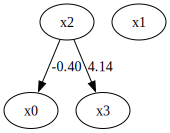

In [7]:
model_causal = lingam.DirectLiNGAM()
X_test = x_train[columns_tmp].values
labels = [f'{i}' for i in X.columns]
model_causal.fit(x_train)
causal_order = [labels[x] for x in model_causal.causal_order_]
causal_order
make_dot(model_causal._adjacency_matrix)

In [1]:
model_causal

NameError: name 'model_causal' is not defined

In [40]:
my_ccsse.df_causal_effects

,from,to,effect
0,Speed,Consumption,2.029315
1,Speed,Time,-1.039779
2,Consumption,Time,3.026721


In [29]:
my_ccsse.run_dict[0].keys()

dict_keys(['original_instance', 'causal_explain', 'list_analyse', 'data_analysis'])

In [38]:
my_ccsse.run_dict[4]['original_instance']

Speed           204.984295
Consumption    1143.039887
Time           4100.018449
Price           824.471518
Name: 895, dtype: float64

In [52]:
my_ccsse.run_dict[8]['list_analyse']

[[[('Time', 4078.3315929976716)],
  Empty DataFrame
  Columns: [from, to, effect]
  Index: [],
  Time    5324.984853
  Name: 834, dtype: float64],
 [[('Speed', 569.84),
   ('Consumption', 1954.208633056678),
   ('Time', 4379.795107405082)],
            from           to    effect
  0        Speed  Consumption  2.029315
  1        Speed         Time -1.039779
  2  Consumption         Time  3.026721,
  Speed           498.367773
  Consumption    1808.505334
  Time           5324.984853
  Name: 834, dtype: float64],
 [[('Consumption', 2668.62), ('Time', 4092.8646771684366), ('Price', 355.76)],
            from    to    effect
  2  Consumption  Time  3.026721,
  Consumption    1808.505334
  Time           5324.984853
  Price           459.124023
  Name: 834, dtype: float64]]

In [8]:
for i in range(len(my_ccsse.run_dict)):
    print(f'posiçao {i}')
    print(f"ORIGINAL")
    print(my_ccsse.run_dict[i]['original_instance'])
    print('-')
    print(my_ccsse.run_dict[i]['list_analyse'])
    print('-')
    print(my_ccsse.run_non_causal_dict[i])
    print('-'*50)

posiçao 0
ORIGINAL
Speed           897.215758
Consumption    2376.601976
Time           7139.785201
Price           913.788444
Name: 191, dtype: float64
-
[[[('Time', 5471.672253235025)], Empty DataFrame
Columns: [from, to, effect]
Index: [], Time    7139.785201
Name: 191, dtype: float64], [[('Consumption', 1805.78), ('Time', 5618.0)],           from    to    effect
2  Consumption  Time  3.026721, Consumption    2376.601976
Time           7139.785201
Name: 191, dtype: float64]]
-
{'solution': [[('Time', 5429.22)], [('Consumption', 1569.19), ('Time', 5674.73)], [('Speed', 994.62), ('Consumption', 1388.87)]]}
--------------------------------------------------
posiçao 1
ORIGINAL
Speed            51.478751
Consumption     953.539232
Time           3303.351391
Price           787.387027
Name: 148, dtype: float64
-
[[[('Time', 3243.65)], Empty DataFrame
Columns: [from, to, effect]
Index: [], Time    3303.351391
Name: 148, dtype: float64], [[('Price', 77.39)], Empty DataFrame
Columns: [from, 

KeyError: 20

In [37]:
my_ccsse.run_non_causal_dict[4]


{'solution': [[('Time', 3631.36)], [('Speed', 367.27)]]}

In [13]:
with open(f"./datasets/results_v3/test.json", "w", encoding="utf-8") as f:
    f.write('')

In [16]:
zxc = pd.read_csv("../periodico/datasets/new_numeric_data/bn1.csv")
zxc = zxc.drop(columns=['Unnamed: 0'])
zxc


,x1,x2,x3,y
0,37.276727,42.462854,11.550201,1.0
1,58.416218,82.262242,14.916557,1.0
2,26.602433,59.778841,11.506535,1.0
3,60.720487,82.257774,16.764501,0.0
4,41.588379,43.001349,11.522822,1.0
...,...,...,...,...
995,38.657639,47.492517,13.372762,0.0
996,35.846863,46.140384,11.528995,1.0
997,45.086106,20.041153,11.547453,0.0
998,90.945436,46.198972,15.561335,0.0


In [17]:
zxc = pd.read_csv("../periodico/datasets/new_numeric_data/bn1.csv")
zxc = zxc.drop(columns=['Unnamed: 0'])

my_ccsse = get_causal_metrics(zxc, "y", 'rf', 'bn1', "./datasets/results_v3")
my_ccsse = get_causal_metrics(zxc, "y", 'rn', 'bn1', "./datasets/results_v3")

class_name = y
columns_tmp = ['x1', 'x2', 'x3', 'y']
              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82        56
         1.0       0.77      0.77      0.77        44

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100

criou o modelo
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
run_causal completo




































































































run_non_causal completo
Quantidade de instâncias contrafactuais = 110
Quantidade de relações causais na base de dados = 3
Quantidade de atributos modificados = 34
Quantidade de instâncias contrafactuais causais = 14
Quantidade de relaç

In [20]:
zxc = pd.read_csv("../periodico/datasets/new_numeric_data/sangiovese.csv")
# zxc = zxc.drop(columns=['Id'])
zxc

# my_ccsse = get_causal_metrics(zxc, "Species", 'rf', 'Iris', "./datasets/results_v3")
# my_ccsse = get_causal_metrics(zxc, "Species", 'rn', 'Iris', "./datasets/results_v3")


,Unnamed: 0,SproutN,BunchN,GrapeW,WoodW,SPAD06,NDVI06,SPAD08,NDVI08,Acid,Potass,Brix,pH,Anthoc,Polyph
0,21,-0.346184,-0.528339,-0.863465,-0.617428,-0.106392,0.050823,-0.198278,0.045205,0.037551,-0.001210,0.104539,-0.038003,0.499180,0.251336
1,46,-0.153031,-0.400980,-0.363443,0.206970,0.006421,0.194551,0.044448,0.003382,0.002642,-0.296872,0.003218,0.009141,-0.008537,-0.238323
2,68,-0.030385,0.015431,0.840254,-0.279058,0.000163,0.105888,0.089827,-0.064657,-0.091271,0.069681,-0.104757,0.008554,-0.288625,-0.096597
3,90,-0.100034,-0.836594,-0.620349,0.063581,0.046857,0.007490,0.115941,0.109238,0.004422,0.349025,-0.044265,0.030596,-0.503229,-0.092977
4,99,-0.021382,0.200724,-0.249094,-0.370807,-0.137172,-0.190638,-0.170088,-0.002560,0.085651,0.056391,-0.043244,-0.006474,0.308487,0.235036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11564,199902,-0.211607,-0.657621,-0.928320,-0.375216,0.038690,0.152729,0.071517,-0.088474,0.132510,0.006472,0.031847,-0.064689,0.125452,-0.120997
11565,199910,-0.082239,-0.731170,-0.318030,-0.065184,0.017228,0.110264,0.048292,0.155814,-0.111687,-0.102326,-0.115347,0.010705,-0.287187,0.024231
11566,199947,-0.375329,0.121556,0.196215,-0.268138,-0.114168,0.053434,0.121302,0.090740,-0.001187,-0.208080,-0.062552,-0.013796,-0.058931,0.047757
11567,199958,-0.009434,0.299270,0.672732,0.987727,0.219766,0.196942,0.303419,0.275963,-0.121843,0.028704,-0.039473,0.034156,-0.189468,-0.108356


In [5]:
X = pd.read_csv('datasets/new_numeric_data/credit_processed.csv')

columns = X.columns
columns_tmp = list(columns)
print(f"class_name = {"NoDefaultNextMonth (label)"}")
print(f"columns_tmp = {columns_tmp}")
columns_tmp.remove("NoDefaultNextMonth (label)")
samples = [10942, 12307, 24192, 7061, 708, 26650, 21800, 4309, 16110, 19178]
# Separa as amostras específicas
df_samples = X.loc[samples]
df_remaining = X.drop(index=samples)

# Separa features e rótulos
x = df_remaining[columns_tmp]
y = df_remaining["NoDefaultNextMonth (label)"]

# Split dos dados restantes
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

# Adiciona os samples removidos ao conjunto de teste
x_test = pd.concat([x_test, df_samples[columns_tmp]])
y_test = pd.concat([y_test, df_samples["NoDefaultNextMonth (label)"]])

# Concatena todos os dados (train + test)
dfx_full = pd.concat([x_train, x_test])
dfy_full = pd.concat([y_train, y_test])

x_train, x_test, y_train, y_test, dfx_full, dfy_full


class_name = NoDefaultNextMonth (label)
columns_tmp = ['NoDefaultNextMonth (label)', 'AGE', 'LastBillAmount', 'TotalOverdueCounts', 'TotalMonthsOverdue']


(       AGE  LastBillAmount  TotalOverdueCounts  TotalMonthsOverdue
 1739    25             480                   1                   7
 17332   29             610                   0                   0
 17779   61            2260                   0                   0
 12858   22             220                   0                   0
 13683   34            2500                   0                   0
 ...    ...             ...                 ...                 ...
 4524    36            1470                   0                   0
 8252    34             240                   0                   0
 26128   30             790                   0                   0
 16434   53             440                   1                   2
 13805   27            2150                   0                   0
 
 [26991 rows x 4 columns],
        AGE  LastBillAmount  TotalOverdueCounts  TotalMonthsOverdue
 15900   24             520                   0                   0
 29757   30        

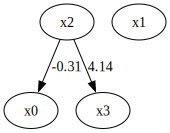

In [6]:
model_causal = lingam.DirectLiNGAM()
X_test = x_train[columns_tmp].values
labels = [f'{i}' for i in X.columns]
model_causal.fit(x_train)
causal_order = [labels[x] for x in model_causal.causal_order_]
causal_order
make_dot(model_causal._adjacency_matrix)

In [ ]:
matrix_error = model_causal.get_error_independence_p_values(dfx_full)
from_list = []
to_list = []
effect_list = []

# Iteração sobre a matriz para extrair os valores e suas posições
for i in range(len(matrix_error)):
    for j in range(i + 1, len(matrix_error[i])):
        if matrix_error[i][j] != 0:
            from_list.append(j)
            to_list.append(i)
            effect_list.append(matrix_error[i][j])

# Criando o DataFrame
df_error = pd.DataFrame({'from': from_list, 'to': to_list, 'effect': effect_list})
labels = [f'{i}' for i in dfx_full.columns]
df_error['from'] = df_error['from'].apply(lambda x : labels[x])
df_error['to'] = df_error['to'].apply(lambda x : labels[x])
df_error.fillna(0, inplace = True)

In [12]:
handler(_, 'rn')

name                                                        Phishing
path                                           Phishing/Phishing.csv
classe                                                         Class
metrica            {"Quantidade de inst\u00e2ncias contrafactuais...
metrica_v2                                                      None
gerou_resultado                                                    1
tamanho                                                       Grande
tipo                                                      Categórica
Name: 27, dtype: object
class_name = Class
columns_tmp = ['having_IP_Address  ', 'URL_Length   ', 'Shortining_Service ', 'having_At_Symbol   ', 'double_slash_redirecting ', 'Prefix_Suffix  ', 'having_Sub_Domain  ', 'SSLfinal_State  ', 'Domain_registeration_length ', 'Favicon ', 'port ', 'HTTPS_token ', 'Request_URL  ', 'URL_of_Anchor ', 'Links_in_tags ', 'SFH  ', 'Submitting_to_email ', 'Abnormal_URL ', 'Redirect  ', 'on_mouseover  ', 'RightCli

Render JSON: 100%|██████████| 1/1 [00:00<00:00, 49.52it/s]


ProfileReport caterogico e acertou
name                                                  Room Occupancy
path                               Room Occupancy/Room Occupancy.csv
classe                                                     Occupancy
metrica            {"Quantidade de inst\u00e2ncias contrafactuais...
metrica_v2                                                      None
gerou_resultado                                                    1
tamanho                                                      Pequena
tipo                                                        Numérica
Name: 28, dtype: object
class_name = Occupancy
columns_tmp = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Occupancy']
remover_valores_invalidos_todas_colunas
Resíduos não-gaussianos. LINGAM pode ser aplicado.
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       167
           1       0.95      1.00      0.98       100

    accuracy           

Render JSON: 100%|██████████| 1/1 [00:00<00:00, 41.09it/s]


ProfileReport numerico e acertou
name                                                           Sonar
path                                        Sonar/sonar.all-data.csv
classe                                                         class
metrica            {"Quantidade de inst\u00e2ncias contrafactuais...
metrica_v2                                                      None
gerou_resultado                                                    1
tamanho                                                       Grande
tipo                                                        Numérica
Name: 29, dtype: object
class_name = class
columns_tmp = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f

Render JSON: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


ProfileReport numerico e acertou
name                                                        Spambase
path                                           Spambase/Spambase.csv
classe                                                         Class
metrica            {"Quantidade de inst\u00e2ncias contrafactuais...
metrica_v2                                                      None
gerou_resultado                                                    1
tamanho                                                       Grande
tipo                                                        Numérica
Name: 30, dtype: object
class_name = Class
columns_tmp = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28', 'F29', 'F30', 'F31', 'F32', 'F33', 'F34', 'F35', 'F36', 'F37', 'F38', 'F39', 'F40', 'F41', 'F42', 'F43', 'F44', 'F45', 'F46', 'F47', 'F48', 'F49', 'F50', 'F51', 'F52', 'F

Render JSON: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


ProfileReport numerico e acertou
name                                                       Student
path               Student/Students-Performance-MAT_processada.csv
classe                                                       Class
metrica                        array must not contain infs or NaNs
metrica_v2                                                    None
gerou_resultado                                                  1
tamanho                                                     Grande
tipo                                                         Mista
Name: 31, dtype: object
class_name = Class
columns_tmp = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'Mjob=at_home', 'Mjob=health', 'Mjob=other', 'Mjob=services', 'Mjob=teacher', 'Fjob=at_home', 'Fjob=he

Render JSON: 100%|██████████| 1/1 [00:00<00:00, 28.51it/s]


ProfileReport misto e acertou
name                                                         titanic
path                                  titanic/titanic_processada.csv
classe                                                      Survived
metrica            Input contains NaN, infinity or a value too la...
metrica_v2                                                      None
gerou_resultado                                                    1
tamanho                                                        Média
tipo                                                           Mista
Name: 32, dtype: object
class_name = Survived
columns_tmp = ['Unnamed: 0', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked=C', 'Embarked=Q', 'Embarked=S', 'Initial= Capt', 'Initial= Col', 'Initial= Don', 'Initial= Dona', 'Initial= Dr', 'Initial= Jonkheer', 'Initial= Lady', 'Initial= Major', 'Initial= Master', 'Initial= Miss', 'Initial= Mlle', 'Initial= Mme', 'Initial= Mr', 'Initial= Mrs', 'Initial= Ms', 'Initia

Render JSON: 100%|██████████| 1/1 [00:00<00:00, 35.88it/s]


ProfileReport misto e acertou
name                                                           Tokyo
path                                                 Tokyo/Tokyo.csv
classe                                                         class
metrica            {"Quantidade de inst\u00e2ncias contrafactuais...
metrica_v2                                                      None
gerou_resultado                                                    1
tamanho                                                       Grande
tipo                                                        Numérica
Name: 33, dtype: object
class_name = class
columns_tmp = ['cpu_avg_user', 'cpu_avg_sys', 'cpu_avg_busy', 'cpu_avg_wait', 'cpu_avg_idle', 'cpu_avg_waste', 'cpu_max_user', 'cpu_max_sys', 'cpu_max_busy', 'cpu_max_wait', 'cpu_max_idle', 'cpu_max_waste', 'cpu_frac_busy', 'io_iget', 'io_bread', 'io_bwrite', 'io_lread', 'io_lwrite', 'io_phread', 'io_phwrite', 'io_wcancel', 'io_namei', 'io_dirblk', 'disk_avg_active', 'disk

Render JSON: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


ProfileReport misto e errou. Certo era Numérica
name                                                         twonorm
path                                             twonorm/twonorm.csv
classe                                                         class
metrica            {"Quantidade de inst\u00e2ncias contrafactuais...
metrica_v2                                                      None
gerou_resultado                                                    1
tamanho                                                        Média
tipo                                                        Numérica
Name: 34, dtype: object
class_name = class
columns_tmp = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'class']
remover_valores_invalidos_todas_colunas
Resíduos não-gaussianos. LINGAM pode ser aplicado.
              precision    recall  f1-score   support

           1       0.96      0.94      0.95       386
  

Render JSON: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


ProfileReport numerico e acertou
name                                                    Vertebral_2C
path                                         Vertebral/column_2C.csv
classe                                                         class
metrica            {"Quantidade de inst\u00e2ncias contrafactuais...
metrica_v2                                                      None
gerou_resultado                                                    1
tamanho                                                      Pequena
tipo                                                        Numérica
Name: 35, dtype: object
class_name = class
columns_tmp = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'class']
remover_valores_invalidos_todas_colunas
Resíduos não-gaussianos. LINGAM pode ser aplicado.
              precision    recall  f1-score   support

    Abnormal       0.92      0.92      0.92        25
      Normal       0.67    

Render JSON: 100%|██████████| 1/1 [00:00<00:00, 63.22it/s]


ProfileReport numerico e acertou
name                                             Votes_Congressional
path               Votes_Congressional/house-votes-84_processada.csv
classe                                                    Class Name
metrica            {"Quantidade de inst\u00e2ncias contrafactuais...
metrica_v2                                                      None
gerou_resultado                                                    1
tamanho                                                        Média
tipo                                                      Categórica
Name: 37, dtype: object
class_name = Class Name
columns_tmp = ['handicapped-infants', 'water-project-cost-sharing', 'adoption-of-the-budget-resolution', 'physician-fee-freeze', 'el-salvador-aid', 'religious-groups-in-schools', 'anti-satellite-test-ban', 'aid-to-nicaraguan-contras', 'mx-missile', 'immigration', 'synfuels-corporation-cutback', 'education-spending', 'superfund-right-to-sue', 'crime', 'duty-free-exp

Render JSON: 100%|██████████| 1/1 [00:00<00:00, 61.67it/s]

ProfileReport caterogico e acertou


0

In [ ]:
dfm_use = pd.read_parquet(f"dfm_use.parquet")
dfm_use.head()

groups = {
    "Australian": ["Australian"],
}

for g in groups:
    df_map_inference_datasets = handler(str(groups[g]), 'rn')
    
df_map_inference_datasets

,name,path,classe,metrica,metrica_v2,gerou_resultado,tamanho,tipo
1,Australian,Australian/Credit_Card_Applications.csv,Class,"{""Quantidade de inst\u00e2ncias contrafactuais...",None,1,Média,Mista
2,Banknote,Banknote/BankNote_Authentication.csv,class,"{""Quantidade de inst\u00e2ncias contrafactuais...",None,1,Pequena,Numérica
3,Biodeg,Biodeg/qsar-biodeg.csv,Class,"{\n ""Quantidade de instâncias contrafactuai...",zero metricas,1,Grande,Numérica
4,Breast Cancer Coimbra,Breast Cancer Coimbra/breast_coimbra.csv,Classification,"{""Quantidade de inst\u00e2ncias contrafactuais...",None,1,Pequena,Numérica
5,Breast Cancer Wisconsin,Breast Cancer Wisconsin/breast-cancer.csv,diagnosis,"{""Quantidade de inst\u00e2ncias contrafactuais...",None,1,Grande,Numérica


In [1]:
dataset_mapping = {
    'Banknote': {'Tamanho': 'Pequena', 'Tipo': 'Numérica'},
    'mammographic_masses': {'Tamanho': 'Pequena', 'Tipo': 'Categórica'},
    'Room Occupancy': {'Tamanho': 'Pequena', 'Tipo': 'Numérica'},
    'liver disorders_bupa': {'Tamanho': 'Pequena', 'Tipo': 'Numérica'},
    'Monk_1': {'Tamanho': 'Pequena', 'Tipo': 'Categórica'},
    'Monk_2': {'Tamanho': 'Pequena', 'Tipo': 'Categórica'},
    'Monk_3': {'Tamanho': 'Pequena', 'Tipo': 'Categórica'},
    'Vertebral_2C': {'Tamanho': 'Pequena', 'Tipo': 'Numérica'},
    'Diabetes': {'Tamanho': 'Pequena', 'Tipo': 'Numérica'},
    'Breast Cancer Coimbra': {'Tamanho': 'Pequena', 'Tipo': 'Numérica'},
    'Heart': {'Tamanho': 'Média', 'Tipo': 'Mista'},
    'Heart_2': {'Tamanho': 'Média', 'Tipo': 'Mista'},
    'EEg': {'Tamanho': 'Média', 'Tipo': 'Numérica'},
    'Australian': {'Tamanho': 'Média', 'Tipo': 'Mista'},
    'Votes_Congressional': {'Tamanho': 'Média', 'Tipo': 'Categórica'},
    'German': {'Tamanho': 'Média', 'Tipo': 'Mista'},
    'Mobile Price Classification': {'Tamanho': 'Média', 'Tipo': 'Numérica'},
    'twonorm': {'Tamanho': 'Média', 'Tipo': 'Numérica'},
    'KC2': {'Tamanho': 'Média', 'Tipo': 'Numérica'},
    'HELOC': {'Tamanho': 'Média', 'Tipo': 'Numérica'},
    'titanic': {'Tamanho': 'Média', 'Tipo': 'Mista'},
    'Phishing': {'Tamanho': 'Grande', 'Tipo': 'Categórica'},
    'Breast Cancer Wisconsin': {'Tamanho': 'Grande', 'Tipo': 'Numérica'},
    'Ionosfera': {'Tamanho': 'Grande', 'Tipo': 'Numérica'},
    'Horse colic': {'Tamanho': 'Grande', 'Tipo': 'Categórica'},
    'Churn': {'Tamanho': 'Grande', 'Tipo': 'Categórica'},
    'Biodeg': {'Tamanho': 'Grande', 'Tipo': 'Numérica'},
    'Student': {'Tamanho': 'Grande', 'Tipo': 'Mista'},
    'Tokyo': {'Tamanho': 'Grande', 'Tipo': 'Numérica'},
    'Spambase': {'Tamanho': 'Grande', 'Tipo': 'Numérica'},
    'Sonar': {'Tamanho': 'Grande', 'Tipo': 'Numérica'},
    'Musk': {'Tamanho': 'Grande', 'Tipo': 'Numérica'}
}

dfm_use = pd.read_parquet(f"dfm_use.parquet")
dfm_use = dfm_use[dfm_use['name'].isin(dataset_mapping.keys())]
dfm_use

dfm_use['tamanho'] = dfm_use['name'].map(lambda x: dataset_mapping[x]['Tamanho'])
dfm_use['tipo'] = dfm_use['name'].map(lambda x: dataset_mapping[x]['Tipo'])
dfm_use.head()

NameError: name 'pd' is not defined

In [26]:
zxc = pd.read_csv("datasets/drive_raw/Australian/Credit_Card_Applications.csv")
# zxc.drop(columns = ['CustomerID'], inplace = True)
# zxc.to_csv("datasets/drive_raw/Australian/Credit_Card_Applications.csv", index = False)
zxc.drop(columns = ['Class'], inplace = True)
zxc

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14
0,1,22.08,11.460,2,4,4,1.585,0,0,0,1,2,100,1213
1,0,22.67,7.000,2,8,4,0.165,0,0,0,0,2,160,1
2,0,29.58,1.750,1,4,4,1.250,0,0,0,1,2,280,1
3,0,21.67,11.500,1,5,3,0.000,1,1,11,1,2,0,1
4,1,20.17,8.170,2,6,4,1.960,1,1,14,0,2,60,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,31.57,10.500,2,14,4,6.500,1,0,0,0,2,0,1
686,1,20.67,0.415,2,8,4,0.125,0,0,0,0,2,0,45
687,0,18.83,9.540,2,6,4,0.085,1,0,0,0,2,100,1
688,0,27.42,14.500,2,14,8,3.085,1,1,1,0,2,120,12


In [27]:
tipo_lista = [0,1,1,1,1,1,1,0,0,1,0,0,1,1]
len(tipo_lista)

14

In [7]:
model_causal = lingam.DirectLiNGAM()
labels = [f'{i}' for i in zxc.columns]
model_causal.fit(zxc)
causal_order = [labels[x] for x in model_causal.causal_order_]
causal_order

['A1',
 'A11',
 'A7',
 'A2',
 'A6',
 'A14',
 'A12',
 'A4',
 'A9',
 'Class',
 'A8',
 'A5',
 'A10',
 'A3',
 'A13']

In [ ]:
['A12', 'A7', 'A10', 'Class', 'A2', 'A5', 'A6', 'A4', 'A14', 'A1', 'A8', 'A9', 'A3', 'A13', 'A11']

In [2]:
def search_causal_order(matrix):
    """Obtain a causal order from the given matrix strictly.

    Parameters
    ----------
    matrix : array-like, shape (n_features, n_samples)
        Target matrix.

    Return
    ------
    causal_order : array, shape [n_features, ]
        A causal order of the given matrix on success, None otherwise.
    """
    causal_order = []

    row_num = matrix.shape[0]
    original_index = np.arange(row_num)
    print(len(matrix))
    while 0 < len(matrix):
        # find a row all of which elements are zero
        row_index_list = np.where(np.sum(np.abs(matrix), axis=1) == 0)[0]
        if len(row_index_list) == 0:
            print('break')
            break

        target_index = row_index_list[0]

        # append i to the end of the list
        causal_order.append(original_index[target_index])
        original_index = np.delete(original_index, target_index, axis=0)

        # remove the i-th row and the i-th column from matrix
        mask = np.delete(np.arange(len(matrix)), target_index, axis=0)
        matrix = matrix[mask][:, mask]
    print(causal_order)
    if len(causal_order) != row_num:
        
        causal_order = None

    return causal_order

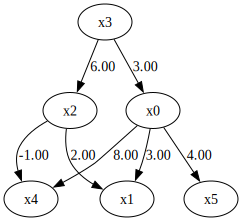

In [23]:
x3 = np.random.uniform(size=1000)
x0 = 3.0*x3 + np.random.uniform(size=1000)
x2 = 6.0*x3 + np.random.uniform(size=1000)
x1 = 3.0*x0 + 2.0*x2 + np.random.uniform(size=1000)
x5 = 4.0*x0 + np.random.uniform(size=1000)
x4 = 8.0*x0 - 1.0*x2 + np.random.uniform(size=1000)
X = pd.DataFrame(np.array([x0, x1, x2, x3, x4, x5]).T ,columns=['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])
X.head()

tipo_lista = [1,1,1,1,1,1]

m = np.array([[0.0, 0.0, 0.0, 3.0, 0.0, 0.0],
              [3.0, 0.0, 2.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 6.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [8.0, 0.0,-1.0, 0.0, 0.0, 0.0],
              [4.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

make_dot(m)

In [17]:
model_causal = lingam.LiM()
model_causal.fit(X.values, np.array([tipo_lista]), only_global=True)
adj_matrix= model_causal._adjacency_matrix
adj_matrix

W_est (without the 2nd phase) is: 
 [[ 0.          0.          0.          0.          0.          4.17705373]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          2.15246658  0.          0.         -0.30903314  0.        ]
 [ 3.41614259  0.          0.          0.          0.          0.        ]
 [ 0.          0.33883259  0.          0.          0.          0.        ]
 [ 0.          0.17936398  0.4183899   0.          1.65993522  0.        ]]


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         4.17705373],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  2.15246658,  0.        ,  0.        , -0.30903314,
         0.        ],
       [ 3.41614259,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.33883259,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.17936398,  0.4183899 ,  0.        ,  1.65993522,
         0.        ]])

In [18]:
asd = search_causal_order(adj_matrix)
asd

6
[1, 4, 2, 5, 0, 3]


[1, 4, 2, 5, 0, 3]

In [19]:
labels = [f'{i}' for i in X.columns]
causal_order_columns = [labels[i] for i in asd]
causal_order_columns

['x1', 'x4', 'x2', 'x5', 'x0', 'x3']

In [20]:
from_list = []
to_list = []
effect_list = []

for i in range(len(adj_matrix)):
    for j in range(len(adj_matrix[i])):
        if adj_matrix[i][j] != 0:
            from_list.append(j)
            to_list.append(i)
            effect_list.append(adj_matrix[i][j])

# Criando o DataFrame
bnm = pd.DataFrame({'from': from_list, 'to': to_list, 'effect': effect_list})
bnm['from'] = bnm['from'].apply(lambda x : labels[x])
bnm['to'] = bnm['to'].apply(lambda x : labels[x])

bnm

,from,to,effect
0,x5,x0,4.177054
1,x1,x2,2.152467
2,x4,x2,-0.309033
3,x0,x3,3.416143
4,x1,x4,0.338833
5,x1,x5,0.179364
6,x2,x5,0.418390
7,x4,x5,1.659935


In [21]:
x3 = np.random.uniform(size=1000)
x0 = 3.0*x3 + np.random.uniform(size=1000)
x2 = 6.0*x3 + np.random.uniform(size=1000)
x1 = 3.0*x0 + 2.0*x2 + np.random.uniform(size=1000)
x5 = 4.0*x0 + np.random.uniform(size=1000)
x4 = 8.0*x0 - 1.0*x2 + np.random.uniform(size=1000)
X = pd.DataFrame(np.array([x0, x1, x2, x3, x4, x5]).T ,columns=['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])
X.head()

,x0,x1,x2,x3,x4,x5
0,1.621405,11.006386,2.832953,0.399581,10.436435,6.818000
1,2.494895,18.883925,5.478865,0.792533,15.446883,10.406998
2,0.708232,4.204516,0.946932,0.126429,5.581730,3.723198
3,0.708858,5.999247,1.884494,0.164753,4.231977,3.488696
4,3.426544,23.441740,6.126420,0.947736,22.152849,13.958101


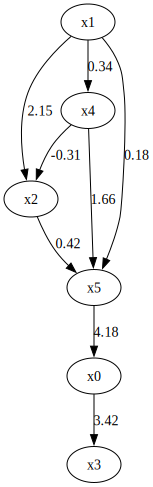

In [22]:
from lingam.utils import make_dot
make_dot(adj_matrix)

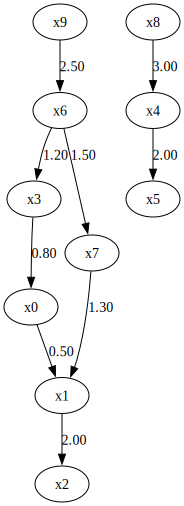

In [24]:
import numpy as np
import pandas as pd

np.random.seed(123)

# Variáveis raízes
z9 = np.random.uniform(size=1000)
z8 = np.random.uniform(size=1000)

# Gerando com base na estrutura causal
z6 = 2.5 * z9 + np.random.uniform(size=1000)
z7 = 1.5 * z6 + np.random.uniform(size=1000)
z4 = 3.0 * z8 + np.random.uniform(size=1000)

z3 = 1.2 * z6 + np.random.uniform(size=1000)
z5 = 2.0 * z4 + np.random.uniform(size=1000)

z0 = 0.8 * z3 + np.random.uniform(size=1000)
z1 = 1.3 * z7 + 0.5 * z0 + np.random.uniform(size=1000)
z2 = 2.0 * z1 + np.random.uniform(size=1000)

# Monta o DataFrame
Z = pd.DataFrame(np.array([z0, z1, z2, z3, z4, z5, z6, z7, z8, z9]).T,
                 columns=['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9'])
Z.head()

adj_matrix = np.array([
#  z0  z1   z2  z3  z4  z5  z6  z7  z8  z9
   [0.0, 0.0, 0.0, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # z0 ← z3
   [0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3, 0.0, 0.0],  # z1 ← z0, z7
   [0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # z2 ← z1
   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2, 0.0, 0.0, 0.0],  # z3 ← z6
   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0],  # z4 ← z8
   [0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # z5 ← z4
   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5],  # z6 ← z9
   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 0.0],  # z7 ← z6
   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # z8 ← raiz
   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # z9 ← raiz
])

adj_df = pd.DataFrame(adj_matrix,
                      columns=['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9'],
                      index=['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9'])
adj_df

make_dot(adj_df)

In [32]:
model_causal = lingam.LiM()
model_causal.fit(Z.values, np.array([[1]*10]), only_global=False)
adj_matrix= model_causal._adjacency_matrix
# adj_matrix

W_est (without the 2nd phase) is: 
 [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         2.05545152 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.12198812 0.         0.         0.21467633 0.         0.
  0.         0.         0.         0.        ]
 [0.39999042 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         2.18272874
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.31093336 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.57219681 0.         0.        ]
 [0.         1.7379242  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         3.14368617 0.
  0.         0.         0.         0.   

In [33]:
asd = search_causal_order(adj_matrix)
# asd

10
[3, 8, 4, 5, 9, 6, 7, 1, 2, 0]


In [34]:
labels = [f'{i}' for i in Z.columns]
causal_order_columns = [labels[i] for i in asd]
# causal_order_columns

In [35]:
from_list = []
to_list = []
effect_list = []

for i in range(len(adj_matrix)):
    for j in range(len(adj_matrix[i])):
        if adj_matrix[i][j] != 0:
            from_list.append(j)
            to_list.append(i)
            effect_list.append(adj_matrix[i][j])

# Criando o DataFrame
bnm = pd.DataFrame({'from': from_list, 'to': to_list, 'effect': effect_list})
bnm['from'] = bnm['from'].apply(lambda x : labels[x])
bnm['to'] = bnm['to'].apply(lambda x : labels[x])

bnm

,from,to,effect
0,z2,z0,1.000000
1,z3,z0,1.000000
2,z7,z1,1.000000
3,z1,z2,1.000000
4,z3,z2,0.214676
5,z8,z4,1.000000
6,z4,z5,1.000000
7,z5,z6,1.000000
8,z9,z6,1.000000
9,z6,z7,1.000000


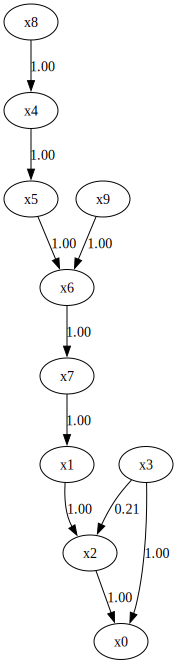

In [36]:
from lingam.utils import make_dot
make_dot(adj_matrix)

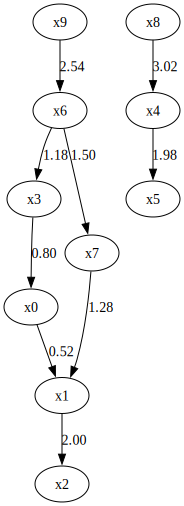

In [31]:
model_causal = lingam.DirectLiNGAM()
labels = [f'{i}' for i in Z.columns]
model_causal.fit(Z)
causal_order = [labels[x] for x in model_causal.causal_order_]
causal_order
make_dot(model_causal._adjacency_matrix)

In [3]:
groups = {
    "Australian": ["Australian"],
}

for g in groups:
    df_map_inference_datasets = handler(str(groups[g]), 'rn')
    
df_map_inference_datasets

name                                                 Australian
path                    Australian/Credit_Card_Applications.csv
classe                                                    Class
metrica       {"Quantidade de inst\u00e2ncias contrafactuais...
metrica_v2                                                 None
Name: 1, dtype: object
              precision    recall  f1-score   support

           0       0.49      1.00      0.66        34
           1       0.00      0.00      0.00        35

    accuracy                           0.49        69
   macro avg       0.25      0.50      0.33        69
weighted avg       0.24      0.49      0.33        69

criou o modelo
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
Start to Running samples
run_causal completo
Quantidade de instâncias contrafactuais = 110

,name,path,classe,metrica,metrica_v2
0,Adult,adult/adult_processada.csv,Above/Below 50K,memoria 18gb,None
1,Australian,Australian/Credit_Card_Applications.csv,Class,"{\n ""Quantidade de inst\u00e2ncias contrafa...",None
2,Banknote,Banknote/BankNote_Authentication.csv,class,"{""Quantidade de inst\u00e2ncias contrafactuais...",None
3,Biodeg,Biodeg/qsar-biodeg.csv,Class,"{\n ""Quantidade de instâncias contrafactuai...",zero metricas
4,Breast Cancer Coimbra,Breast Cancer Coimbra/breast_coimbra.csv,Classification,"{""Quantidade de inst\u00e2ncias contrafactuais...",None
5,Breast Cancer Wisconsin,Breast Cancer Wisconsin/breast-cancer.csv,diagnosis,"{""Quantidade de inst\u00e2ncias contrafactuais...",None
6,Churn,Churn/WA_Fn-UseC_-Telco-Customer-Churn_process...,Churn,"Input contains NaN, infinity or a value too la...",None
7,Compas,Compas/compas-scores-two-years.csv,two_year_recid,base de dados nao processada,None
8,Credit default,Credit default/UCI_Credit_Card.csv,default.payment.next.month,memoria,None
9,Diabetes,Diabetes/diabetes.csv,Outcome,"{""Quantidade de inst\u00e2ncias contrafactuais...",None


In [10]:
import pandas as pd

# Dados
data = {
    "x_0": [96, 206, 577, 93],
    "x_1": [62, 136, 438, 77],
    "x_2": [59, 181, 537, 24],
    "x_3": [76, 196, 603, 3],
    "x_4": [12, 41, 191, 79]
}

# Transpor para deixar cada $x_i$ como linha
df = pd.DataFrame(data, index=["as", "ac", "at", "ap"]).T

df


,as,ac,at,ap
x_0,96,206,577,93
x_1,62,136,438,77
x_2,59,181,537,24
x_3,76,196,603,3
x_4,12,41,191,79


In [11]:
model_causal = lingam.LiM()
model_causal.fit(df.values, np.array([[1,1,1,1]]), only_global=True)
model_causal._adjacency_matrix

W_est (without the 2nd phase) is: 
 [[ 0.          2.21185572 -1.23763873  2.29213625]
 [ 0.          0.          3.25509843 -0.61611709]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.91046437  0.        ]]


array([[ 0.        ,  2.21185572, -1.23763873,  2.29213625],
       [ 0.        ,  0.        ,  3.25509843, -0.61611709],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.91046437,  0.        ]])

In [12]:
def search_causal_order(matrix):
    """Obtain a causal order from the given matrix strictly.

    Parameters
    ----------
    matrix : array-like, shape (n_features, n_samples)
        Target matrix.

    Return
    ------
    causal_order : array, shape [n_features, ]
        A causal order of the given matrix on success, None otherwise.
    """
    causal_order = []

    row_num = matrix.shape[0]
    original_index = np.arange(row_num)
    print(len(matrix))
    while 0 < len(matrix):
        # find a row all of which elements are zero
        row_index_list = np.where(np.sum(np.abs(matrix), axis=1) == 0)[0]
        if len(row_index_list) == 0:
            print('break')
            break

        target_index = row_index_list[0]

        # append i to the end of the list
        causal_order.append(original_index[target_index])
        original_index = np.delete(original_index, target_index, axis=0)

        # remove the i-th row and the i-th column from matrix
        mask = np.delete(np.arange(len(matrix)), target_index, axis=0)
        matrix = matrix[mask][:, mask]
    print(causal_order)
    if len(causal_order) != row_num:
        
        causal_order = None

    return causal_order

asd = search_causal_order(model_causal._adjacency_matrix)
asd

4
[2, 3, 1, 0]


[2, 3, 1, 0]

In [22]:
labels = [f'{i}' for i in X.columns]

causal_order_columns = [labels[i] for i in asd]
causal_order_columns

['x1', 'x4', 'x2', 'x5', 'x0', 'x3']

In [25]:
matrix = model_causal._adjacency_matrix
from_list = []
to_list = []
effect_list = []

for i in range(len(matrix)):
    for j in range(len(matrix[i])):
        if matrix[i][j] != 0:
            from_list.append(j)
            to_list.append(i)
            effect_list.append(matrix[i][j])

# Criando o DataFrame
bnm = pd.DataFrame({'from': to_list, 'to': from_list, 'effect': effect_list})
labels = [f'{i}' for i in X.columns]
bnm['from'] = bnm['from'].apply(lambda x : labels[x])
bnm['to'] = bnm['to'].apply(lambda x : labels[x])

bnm

,from,to,effect
0,x0,x5,4.183060
1,x2,x1,2.174203
2,x2,x4,-0.285400
3,x3,x0,3.413356
4,x4,x1,0.329998
5,x5,x1,0.184035
6,x5,x2,0.417841
7,x5,x4,1.646828


In [16]:
make_dot(matrix)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH